In [1]:
#pip install jupyter
#pip install matplotlib
#pip install numpy
#pip install scipy
#pip install astropy

In [2]:
import numpy as np
#%pylab inline

# Mosaicing
Use the cell below to create a cube representing the weights or the sensitivity of a mosaic (in dependence of frequency, hence three dimensions). Notice that at this stage the single rms is either entered by hand or the HI line sensitivity can be calculated providing some parameters, but it is not considered to vary with frequency (only across the primary beam).

The peak rms for a single primary beam is entered with the parameter rmssingle (in Jy). If the parameter rmsbeam is entered as the string "calculate", the script calculates the rms from the parameters hours (integration time in hours), Nant (number of antennas), HI velocity_width (HI velocity window over which to calculate the sensitivity)  # in km/s, obs_freq (observation frequency in Hz), f_tap (the weighting factor or penalty, a simple factor to increase the thermal rms by to account for the effects of using weighting schemes differing from natural weighting).

The user determines the size of the cube by providing the upper and lower boundaries. These are determined by the variables RAmin (minimum right ascension of cube in deg), RAmax (maximum right ascension of cube in deg), Demin (minimum declination of cube in deg), Demax (maximum declination of cube in deg), numin (minimum frequency of cube in Hz), numax (maximum frequency of cube in Hz). The voxel size is determined by the spatial voxel size cdeltxy (in deg) and the frequency voxel size cdeltnu in Hz.

The positions of the pointings are provided in a list ras of right ascensions ras and declinations de, either as floats in units of deg or in hexagesimal units (provided as strings). Optionally, the user supplies names for the pointings in a list names of strings. 

Alternatively, the user can automatically generate a grid confined by a polygon, if she sets grid_from_polygon = True
The vertices are given by polypointsx and polypointsy, which are lists of numpy-readable angles (e.g. 15.0, '15deg', '1h00m00s', '15d00m00s' all for 15 deg). The regular polygonal grid, either 'hexagonal' or 'quadradic' (determined by parameter gridtype), has a separation of sep for the grid points (sep in units of degrees), and is tilted by the angle tilt (in degrees). The lateral shift of the grid is determined by the position given by the pair startpoint, and is by default the barycentre of the grid, if startpoint = None. Startpoint should be chosen to lie inside the polygon. The parameter border (in degrees) determines a border of the grid towards the polygon. If border is positive, no grid point can have a distance lower than border towards the input polygon. If border is negative, grid points outside the polygon are allowed if their distance to a side of the polygon is less than the absolute value of border. The pointings are automatically named prefix-number using the parameter prefix as a prefix and increasing integers starting with 00.

The parameter pbshape determines the shape of the primary beam 'Tapered Cos Squared' (see Mauch, et al. 2020, ApJ, 888, 61) or Gaussian. The script will first calculate a weight map (or rather a cube with frequency as the third axis), the inverse of the noise map in units of the inverse of rmsrel. If rmsrel is chosen to be the rms at the centre of a single pointing (same as rmsbeam), this shows hence the increase in signal-to-noise (sensitivity) relative to the signal-to-noise (sensitivity) at the centre of a single beam. The weight map (cube) can be returned as a fits data cube with the name specified in the parameter weightmapname. Then the noise map, the inverse of the weight map (cube) in units of Jy is calculated, clipped at values above the clipper parameter. This map (cube), representing the expected rms across the field, can be saved as a fits file with the name rmsmapname.

In the following some statistics is carried out for pixel values in the noise cube below the clip value statmax and, if a polygon was specified, inside the polygon. A viewgraph is generated showing the area having an rms noise below a threshold rms_max. This, togeter with the numbers is the important figure of merit, which shows you whether your mosaic is wisely chosen. Assuming your science requires an rms of xxx, then you can determine the area that you are covering at this rms and below from this viewgraph. The numbers calculated for the polygon can show you these quantities in your region of interest. The plot can be generated in the format of your choice (e.g. pdf) using the parameter rms_statistics_plot (e.g. rms_statistics_plot = 'rms_statistics.pdf').

A map is presented showing the weights cube as a greyscale map with a minimum vmin and maximum vmax for the colour wedge and showing the rms as contours, the levels of which are provided by the user in the list rmscontours. This is done for the channel mapchannel (index starting with 0) in the rms/weights cube. The plot can be generated in the format of your choice (e.g. pdf) using the parameter pointpos_plot (e.g. pointpos_plot = 'pointpos.pdf')

Finally, the mosaic pointings are listed, and can be redirected into a csv file in a format accepted by the MeerKAT observing tool using the parameter pointpos_ascii (e.g. pointpos_ascii = 'pointpos.csv')

In [48]:
import warnings
warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [49]:
# These should be specified by the user
# For queries contact GIGJ

# Rms in a single pointing
# rmsbeam = 0.001 # peak rms for all beams in Jy, this can also be a list with rmss per beam
rmssingle = 'calculate' # Either a float providing the central rms in a single pointing or 'calculate'

# Parameters to use for the automated calculation of the rms, ignore if rms_single is not 'calculate'
hours = 16               # Time in Hours
Nant = 60                # Number of Antennas
velocity_width = 5.513   # in km.s^1, 32k-mode: 5.513 km/s, 4k-mode: 44.108 km/s, n-mode:856000/n
obs_freq =1.421e9        # Observation frequency in Hz
f_tap = 1.               # The weighting factor. Choose 1. for natural weighting, 1.5 for Robust 0

# Determine size of cube
RAmin = 35. # minimum right ascension of cube in deg
RAmax = 40. # maximum right ascension of cube in deg
Demin = -16. # minimum declination of cube in deg
Demax = -13. # maximum declination of cube in deg
numin = 1300000000. # minimum frequency of cube in Hz
numax = 1400000000. # maximum frequency of cube in Hz
cdeltxy = 0.011 # spatial voxel size in deg
cdeltnu = 10000000 # frequency voxel size in Hz

# Information about pointings and rms, fits file names
ras  = [ 37.,  38.,  37. ,  38. ,  37.,  38.] # Pointings (right ascension, list in deg or hexagesimal, e.g ['02h30m0s','02h45m0s'])
decs = [-14., -14., -14.5, -14.5, -15., -15.] # Pointings (declination, list in deg or hexagesimal, e.g ['-15d00m0s','-17d30m0s'])
names = ['a','b','c','d','e','f'] # Names of pointings, alternatively empty list for no names

# Or use functionality to create a grid, notice that above values are overridden
grid_from_polygon = True
polypointsra =  [ 35.5, 38., 38., 39.5, 36.5] # Corners of polygon delimiting grid, right ascension in astropy-readable units 
polypointsdec = ['-14d00m00s', -13.2, -14., -15., -15.] # Corners of polygon delimiting grid, declination in astropy-readable units
sep = 0.5 # Separation of grid points in degree
border = 0.1 # Separation from polygon in degree
tilt= 15. # Rotation of grid points in degrees
gridtype = 'hexagonal' # Type of grid, 'quadratic' or 'hexagonal'
startpoint = None
prefix = 'p'

pbshape = 'Tapered Cos Squared' # Primary beam shape
rmsrel = 'rmsbeam' # Either a float or 'noise', if the latter, rmsbeam is used as a reference
weightmapname = 'weights.fits' # name of weights cube, use empty string if not wanted
clipper = 0.01 # Clip of noise map in Jy
rmsmapname = 'rms.fits' # Fitsfile with rms, use empty string if not wanted

# Plotting and statistics
statmax = 0.00075 # Generate statistics for voxels below this limit

mapchannel = 9 # Channel to plot an also be provided as a frequency in astropy units
vmin = 0. # Plot lower limit for greyscale
vmax = 1.5 # Plot upper limit for greyscale
rmscontours = [0.00005, 0.0001, 0.0002, 0.0004] # contours to plot rms in mosaic

rms_statistics_plot = 'rms_statistics.pdf' # Statistics plot, set to '' if not required
pointpos_plot = 'pointpos.pdf'
pointpos_ascii = 'pointpos.csv'

T_sys/eta at 1421 MHz is 19.7K
Natural rms noise after 16.0h on-source is 0.1166 mJy/beam over 5.51 km/s
Rms noise when applying a penalty of 1 is 0.1166 mJy/beam over 5.51 km/s
In the following we assume an rms of 0.1166 mJy/beam
The weight map generated is 1 for a value of 0.1166 mJy/beam
Below a threshold of 0.75 mJy
   the maximum sensitivity is 0.750 mJy
   the minimum sensitivity is 0.066 mJy
   the average sensitivity is 0.222 mJy
   the standard deviation in sensitivity is 0.168 mJy
Inside the polygon provided
   the maximum sensitivity is 0.545 mJy
   the minimum sensitivity is 0.066 mJy
   the average sensitivity is 0.097 mJy
   the standard deviation in sensitivity is 0.031 mJy


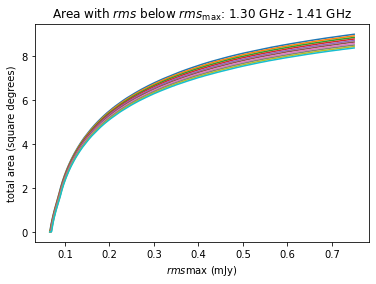

In [50]:
##############################################################################################################
# you can but you don't have to change the following (better don't touch unless you know what you are doing) #
##############################################################################################################
# For queries contact GIGJ

import numpy as np
import matplotlib.pyplot as plt
from astropy import constants
from astropy.io import fits
from astropy import coordinates
from astropy import wcs
from astropy import units

# Constants and conversion factors
k = 1.38e-23
J = 1e26                                   # Jy to Watts conversion factor
c = 2.99792456e8
h1 = 1420405751.7667                       # HI frequency in Hz
diameter = 13.5 # MeerKAT diameter in m
totbandw = 856000000 # total bandwidth in Hz
totchann = 4096 # total channels (not very relevant)

rmsbeam = rmssingle

if rmsbeam == 'calculate':
    # Fitted values from recent work. Tsys/eta
    specs = np.array([[ 900.        ,   23.95144954],
           [ 950.        ,   23.33837709],
           [1000.        ,   23.10850831],
           [1050.        ,   22.70384223],
           [1100.        ,   21.93645197],
           [1150.        ,   22.16621671],
           [1200.        ,   21.52095707],
           [1250.        ,   20.86545365],
           [1300.        ,   20.20854385],
           [1350.        ,   19.86267232],
           [1400.        ,   19.73085187],
           [1450.        ,   19.72759109],
           [1500.        ,   19.79424543],
           [1550.        ,   19.94109374],
           [1600.        ,   20.23018655],
           [1650.        ,   20.86337011]])

    f = specs[:,0]*1e6                         # frequency axis above, Hz
    NPol = 2
    A = np.pi * (diameter/2)**2
    Tsys_eta = specs[:,1]
    bw = h1/c*velocity_width*1000.
    tau = 3600 * hours
    Tsys_per_eta = Tsys_eta[np.argmin(np.abs(f - obs_freq))]
    print ("T_sys/eta at %3.0f MHz is %2.1fK"%(obs_freq/1e6,Tsys_per_eta) )
    rmsnat = 2 * k * Tsys_per_eta / (A * np.sqrt(Nant * (Nant-1) * bw * tau)) * J / np.sqrt(NPol)
    rmsbeam = f_tap*rmsnat
    print("Natural rms noise after {:.1f}h on-source is {:2.4g} mJy/beam over {:.2f} km/s".format(hours, rmsnat*1e3, velocity_width))
    print("Rms noise when applying a penalty of {:.4g} is {:2.4g} mJy/beam over {:.2f} km/s".format(f_tap, rmsbeam*1e3, velocity_width))
print('In the following we assume an rms of {:2.4g} mJy/beam'.format(rmsbeam*1e3))

if rmsrel == 'rmsbeam':
    rmsrel = rmsbeam
print('The weight map generated is 1 for a value of {:2.4g} mJy/beam'.format(rmsrel*1e3))

# Create mosaic using polygon

def returnradecindeg(ra, dec):
    """
    Uses ra and dec as an input in a astropy-readable format and returns [ra, dec] in degrees.
    """
    
    # Pointings can be given in any string understood by astropy or in decimals, in which case they would be deg
    try:
        wcscoords = coordinates.SkyCoord(ra, dec, frame='icrs')
    except:
        try:
            wcscoords = coordinates.SkyCoord(ra, dec, frame='icrs', unit='deg')
            ra = wcscoords.ra.deg
            dec = wcscoords.dec.deg
        except ValueError:
            print('Wrong format for pointings')
    return [wcscoords.ra.deg, wcscoords.dec.deg]


#def convertodeg(listofpointsx, listofpointsy):
#    """
#    Takes listofsides, which is a list of lists and converts each entry into degrees using hex format
#    Input:
#    listofpointsx (list of lists):
#
#    Convert any astropy readable format to degree
#    """
#    degpoints = []
#    for i in range(len(listofpointsx)):
#        degpoints.append(returnradecindeg(listofpointings[i][0], listofpointings[i][1]))
#    return degpoints
    
def convertosides(polypointsx, polypointsy):
    """
    Takes polypoints describing the corners of a polygon and returns list of quadruples describing sides of polygon 
    Input:
    polypointsx (list of float): corners of the polygon in a consecutive order, any format, x
    polypointsy (list of float): corners of the polygon in a consecutive order, any format, y
    
    Output will be [[x1,x2,y1,y2], ...]
    """
    sides = []
    for i in range(len(polypointsx)-1):
        sides.append([polypointsx[i], polypointsx[i+1], polypointsy[i], polypointsy[i+1]])
    sides.append([polypointsx[len(polypointsx)-1], polypointsx[0], polypointsy[len(polypointsx)-1], polypointsy[0]])
    return sides

def outpolygon(point, sidesofpolygon, border):
    """
    Determines whether point in part of polygon described by sidesofpolygon
    
    Input:
    point (pair of float): x and y coordinate of polygon
    sidesofpolygon (list of quadrupel of float): list of sides of polygon [[x1,x2,y1,y2], ...]
    border: Maximally allowed distance from polygon, if positive the mosaic is shrinked inside
            the polygon, if negative, it is expanded.
    
    Return: True (point is outside of polygon) or False (point is inside of polygon)
    """
    i = 0
    for side in sidesofpolygon:
        if point[0] < max(side[0:2]) and point[0] > min(side[0:2]):
            if side[2]+(point[0]-side[0])*(side[3]-side[2])/(side[1]-side[0]) > point[1]:
                i += 1
    # point inside polygon
    if i%2 > 0:
        thareturn = False
    
    # point outside polygon
    else:        
        thareturn = True

    if thareturn:
        if border < 0:
            for lseg in sidesofpolygon:
                if distpointlseg(point, lseg) < fabs(border):
                    thareturn = not thareturn
                    break
    else:
        if border > 0:
            for lseg in sidesofpolygon:
                if distpointlseg(point, lseg) < fabs(border):
                    thareturn = not thareturn
                    break
                    
    return thareturn  

def getgridaroundpoint(point, sep, tilt, gridtype = 'hexagonal'):
    """
    Calculate a grid cell around point
    
    Input:
    point (pair of float): The central point of the grid cell
    sep (float)          : Separation of grid points
    tilt (float)        : Rotation of grid in degrees
    gridtype (string)    : 'hexagonal' or 'quadratic'
    
    Calculates first a set of grid points with distance sep from point of type gridtype,
    then rotates it anticlockwise by tilt, returns points as list of pairs
    
    """
    listofpoints = []
    
    if gridtype == 'hexagonal':
        # These are [cos(angle), sin(angle), ...], where angle is 0, 60 deg, 120 deg, 180 deg, 240 deg, 300 deg, 360 deg
        cossins = [[1.,0.],[0.5,np.sqrt(3.)/2.],[-0.5,np.sqrt(3.)/2],[-1.,0.], [-0.5,-np.sqrt(3.)/2.],
                   [0.5,-np.sqrt(3.)/2]]
    else:
        # And these [cos(angle), sin(angle), ...], where angle is 0, 90 deg, 180 deg, 270 deg
        cossins = [[1.,0.],[0.,1.],[-1.,0.],[-1.,-1]]
    for cossin in cossins:
        listofpoints.append([cossin[1]*sep, cossin[0]*sep])
 
    # Now rotate
    cossin = [np.cos(np.pi*tilt/180), np.sin(np.pi*tilt/180)]
    
    finalpoints = []
    for xy in listofpoints:
        finalpoints.append([cossin[0]*xy[0]-cossin[1]*xy[1]+point[0],cossin[1]*xy[0]+cossin[0]*xy[1]+point[1]])
    return finalpoints

def distpointlseg(point, lseg):
    """
    Calculate the distance between point [q0,q1] and line segment [a0,b0,a1,b1]
    Input:
    point (pair of float)    : The point
    lseg (quadruple of float): The line segment two x-values followed by two y-values
    """
    m = lseg[1]-lseg[0]
    n = lseg[3]-lseg[2]
    r = point[0]-lseg[0]
    k = point[1]-lseg[2]
    o = point[0]-lseg[1]
    l = point[1]-lseg[3]
    
    if n == 0.:
        x = m*(r+n*k/m)/(m*m+n*n)
    else:
        x = n*(k+r*m/n)/(m*m+n*n)
    
    # If the lot is between the two points confining the line segment, calculate the distance between the lot 
    # and the point
    if x < 1 and x > 0:
        d = np.sqrt(np.power(r-x*m,2)+np.power(k-x*n,2))
    else:
        d = np.sqrt(np.min([np.power(r,2)+np.power(k,2),np.power(o,2)+np.power(l,2)]))
    return d
                            
def populategrid(sep, tilt, polypointsra, polypointsdec, gridtype = 'hexagonal', startpoint = None, 
                 border = 0., prefix = 'p'):
    """
    Populate a grid inside a polygon defined by listofpoints
    Input:
    sep (float)                                  : Separation of grid points in degrees
    tilt:  (float)                               : Rotation of grid in degrees
    polypointsra (list of astropy readable)      : Points of polygon, ra
    polypointsdec (list of astropy readable)     : Points of polygon, dec
    gridtype (string)                            : 'hexagonal' or 'quadratic'
    startpoint (None or pair of astropy readable): Starting point for the grid, take barycentre if None
    border (float)                               : Border between grid and polygon in degrees
    prefix (string)                              : Prefix to pointing names
    
    Populates a grid confined by a polygon, whose corners are given by polypointsx and polypointsy, which are lists
    of numpy-readable angles (e.g. 15.0, '15deg', '1h00m00s', '15d00m00s' all for 15 deg). The regular polygonal grid,
    either hexagonal or quadradic,has a separation of sep for the grid points, and is tilted by the angle tilt 
    (in degrees). The lateral shift of the grid is determined by the position given by the pair startpoint, and by 
    default the barycentre of the grid. startpoint should be inside the polygon. The parameter border determines a 
    border of the grid towards the polygon. No grid point can have a distance lower than border towards the input 
    polygon. Returns triplet with right ascentsions in deg, declinations in deg, pointing name = prefix+number, 
    number starting with 0. 
    """
    if sep < 0.02:
        tol = sep/10.
    else:
        tol = 0.01
    
    # Convert it all to deg
    polyra, polydec = returnradecindeg(polypointsra, polypointsdec)
    
    # Convert to pixel coordinates
    # Get centre of pointing
    if type(startpoint) == type(None):
        startpoint = [np.average(np.array(polyra)), np.average(np.array(polydec))]
        
    # Create a new WCS object, 2 axes
    w = wcs.WCS(naxis=2)

    # Set up a sin projection, pixels in 1 deg
    w.wcs.cdelt = [-1., 1.]
    w.wcs.crpix = [1., 1.]
    w.wcs.crval = startpoint
    w.wcs.ctype = ['RA---SIN', 'DEC--SIN']
    w.wcs.cunit = ['deg', 'deg']
    w.wcs.equinox = 2000.
    w.wcs.set()
    
    # Get the pixel coordinates
    dapoints = np.array(list(zip(polyra,polydec)))
    polyradec = w.wcs_world2pix(dapoints,0).T.tolist()
    polyra = polyradec[0][:]
    polydec = polyradec[1][:]
    
#populategrid(sep, tilt, polypointsra, polypointsdec)

    # Convert polygon to sides
    sides = convertosides(polyra, polydec)

    # calculate pointings
    pointings = w.wcs_world2pix([startpoint],0).tolist()
    newfound = True
    
    #populategrid(sep, tilt, polypointsra, polypointsdec)    
    while newfound:
        
        # Go through the list of pointings and add pointings when new ones around old ones are found
        newfound = False
        for pointing in pointings:
            
            # Generate pointings
            newpointings = getgridaroundpoint(pointing, sep, tilt, gridtype = gridtype)
            
            # Check the pointings if they are inside the polygon
            popped = 0
            for i in range(len(newpointings)):
                    if outpolygon(newpointings[i-popped],sides, border):
                        newpointings.pop(i-popped)
                        popped += 1
            
            # Check if pointing already exists
            for oldpointing in pointings:
                popped = 0
                for i in range(len(newpointings)):
                    if np.sqrt(np.power(newpointings[i-popped][0]-oldpointing[0],2)+
                               np.power(newpointings[i-popped][1]-oldpointing[1],2)) < tol:
                        newpointings.pop(i-popped)
                        popped += 1
                   
            if len(newpointings) > 0:
                    newfound = True
                    pointings = pointings + newpointings
                    
    # Transpose to separate x and y
    world = w.wcs_pix2world(pointings, 0)
    pointings = world.T.tolist()
    names = []
    for i in range(len(pointings[0])):
        names.append('{:s}{:02d}'.format(prefix,i))
    return pointings+[names]

# Calculate grid if desired
if grid_from_polygon:
    ras, decs, names = populategrid(sep, tilt, polypointsra, polypointsdec, gridtype = gridtype, startpoint = startpoint, 
                 border = border, prefix = prefix)

def create_wdh(RAmin, RAmax, Demin, Demax, numin, numax, cdeltxy, cdeltnu = None, totbandw = None, totchann = 4096):
    """
    Create a astropy wcs object, an empty numpy cube, and pyfits header object in sin projection from scratch
    RAmin     (float): Minimum right ascension of cube in deg
    RAmax     (float): Maximum right ascension of cube in deg
    Demin     (float): Minimum declination of cube in deg
    Demax     (float): Maximum declination of cube in deg
    numin     (float): Minimum frequency of cube in Hz
    numax     (float): Maximum frequency of cube in Hz
    cdeltxy   (float): Spatial voxel size
    cdeltnu   (float): Frequency voxel size (will be calculated from chann if not provided)
    totbandw  (float): Reference bandwidth to calculate cdeltfreq from, defaults to numax-numin
    totchann  (float): Total channel number to calculate cdeltfreq with cdeltfreq = bandw/chann
    """

    # Determine sizes
    npixy = int((Demax-Demin)/cdeltxy) 
    npixx = int((RAmax-RAmin)*np.cos(np.fabs(np.pi*(Demin+Demax)/(2*180.)))/cdeltxy)
    
    if type(totbandw) == type(None):
        totbandw = numax-numin
    
    if type(cdeltnu) == type(None):
        cdeltnu = totbandw/totchann
    
    bandw = numax-numin
    npixz = int(bandw/cdeltnu)
    
    # Create a new WCS object, 3 axes
    w = wcs.WCS(naxis=3)

    # Set up a sin projection
    w.wcs.cdelt = [-cdeltxy, cdeltxy, cdeltnu]
    w.wcs.crpix = [npixx/2., npixy/2., 1]
    w.wcs.crval = [(RAmax+RAmin)/2., (Demax+Demin)/2., numin+bandw/(2*npixz)]
    w.wcs.ctype = ['RA---SIN', 'DEC--SIN', 'FREQ-OBS']
    w.wcs.cunit = ['deg', 'deg', 'Hz']
    w.wcs.equinox = 2000.
    w.wcs.set()

    # Build the data array
    data = np.zeros([npixz,npixy,npixx], dtype=np.float32)
    
    # Create header
    header = w.to_header()
    return [w,data,header]

w, data, header = create_wdh(RAmin, RAmax, Demin, Demax, numin, numax, cdeltxy, cdeltnu = cdeltnu, totbandw = totbandw, totchann = totchann)

def pointingweightcube(w, data, ra, dec, rmsbeam = 1., rmsrel = 1., pbshape = 'Tapered Cos Squared'):
    """
    Add quadradically an array representing a weight map given a grid of Gaussian primary beams relative to ra and dec
    with the same shape as data, then return the inverse

    w (WCS structure)                       : WCS structure describing the coordinate system and the cube
    data (ndarray)                          : Numpy array, input data cube
    ra (float, astropy coordinate, or list) : Right ascension centre of pointing
    dec (float, astropy coordinate, or list): Declination centre of pointing
    rmsbeam (list of float)                 : rms for each pointing relative to a reference value
    rmsrel (reference rms)                  : rmsbeam will be divided by rmsrel before creating the cube
    pbshape (str)                           : Shape of the primary beam 'Tapered Cos Squared' (see Mauch, et al. 
                                               2020, ApJ, 888, 61) or Gaussian
    
    Takes as input astropy WCS object and a corresponding numpy data cube to create a noise weight map
    of the dimensions and projection of the input cube. A list of right ascensions and a list of declinations 
    in either float or astropy format (alternatively a single value can be provided) determines the positions of
    pointings. Around each of those pointings, a Gaussian primary beam attenuation is calculated, according to 
    MeerKAT specs, multiplied by the inverse of rmsbeam, which is a list of floats (each float corresponding to
    the corresponding beam, values will be extrapolated) or a number. Those attenuation patterns are added in 
    quadrature and a square root is taken at the end. The resulting pattern then reflects a weight pattern, 
    whose inverse is proportional to the rms. The inverse will be returned and clipped at clip (using nan for 
    other values)
    """
    
    # Convert to lists
    if type(ra) != type([]):
        ra = [ra]
    if type(dec) != type([]):    
        dec = [dec]
    if type(rmsbeam) != type([]):    
        rmsbeam = [rmsbeam]
  
    # Convert weights to extrapolated list
    for i in range(len(ra)):
        if len(rmsbeam) == i:
            rmsbeam.append(rmsbeam[i-1])
 
    ra, dec = returnradecindeg(ra, dec)
    
    # Make a copy of the input cube
    basedata = np.zeros(data.shape, dtype = data.dtype)
    
    for i in range(len(ra)):
        
        # Get the pixel coordinates
        pixcrd = w.wcs_world2pix([[ra[i],dec[i],w.wcs.crval[2]]], 0)
    
        world = w.wcs_pix2world(pixcrd, 0)

        # Create image where pixels are distances from pointing squared in deg squared
        datacube = np.indices((basedata.shape[1],basedata.shape[2]), dtype = basedata.dtype)
        datacube[0] -= pixcrd[0,1]
        datacube[1] -= pixcrd[0,0]

        # Distance from selected position squared
        datacube = np.power(datacube,2).sum(axis=0)

        # Add frequency axis and change values to deg squared
        datacube.resize((1, basedata.shape[1], basedata.shape[2]))
        datacube = np.repeat(datacube, basedata.shape[0], axis=0)*np.power(w.wcs.cdelt[1],2)

        # Get an array with the right frequencies using wcs
        parray = np.stack((np.zeros(basedata.shape[0]),np.zeros(basedata.shape[0]),
                               np.arange(basedata.shape[0])), axis=-1)
        nu = w.wcs_pix2world(parray, 0)[:,2]

        if pbshape == 'Gaussian':

            # Calculate the Gaussian: (exp(-r^2/(2*sigma^2)))^2 = exp(-r^2/sigma^2), using degrees as unit
            # sigma_deg = HPBW_deg/sqrt(log(256)) HPBW_deg = 180*HPWB/pi HPBW = 1.02 lamda/D 
            # lambda = c/nu => 
            # sigma = 180 * 1.02 * c/(D*nu*sqrt(log(256))*pi)

            # We go directly to the denominator in the exponent, which is sigma^2
            # This would be the long way
            # sigma = 180.*1.02*constants.c.value/(diameter*nu*np.pi*np.sqrt(np.log(256)))
            # denominator = 2.*np.power(sigma,2)
            # This saves the power later on (notice that this is sigma squared)
            denominator = np.power(180.*1.02*constants.c.value/(diameter*nu*np.pi),2)/(np.log(256))
    
            # Now make an array of it to use with the cube
            denominator.resize((basedata.shape[0], 1, 1))
    
            # Calculate the Gaussian
            basedata += np.exp(-datacube/denominator)/np.power(rmsbeam[i],2)
        else:
            # tapered Gaussian, cut-off at first Null
            #FWHM/arcmin = 87.83/nu/GHz 
            # freq in Hz, fwhm in degrees
            fwhm = 8.783e10/(60.*nu)

            fwhm.resize((basedata.shape[0], 1, 1))
            theta = np.sqrt(datacube)
            # a = (np.cos(1.189*np.pi*(theta/FWHM))/(1-4*(1.189*(theta/FWHM))**2))**2
            datacube = pow((pow(np.cos(1.189*np.pi*(theta/fwhm))/(1-4*pow(1.189*(theta/fwhm),2)),2))/rmsbeam[i],2)
            # datacube[(1.189*theta/fwhm) > 0.5] = 0.
            # Clip at a value of a primary beam of 0.2, keep in mind that this is the squared value
            datacube[datacube < 0.04] = 0.
            basedata += datacube

    # Returning the square root
    return rmsrel*np.sqrt(basedata)

def invertweightmap(data, clipper = 1., rmsrel = 1.):
    """
    Invert map and clip inverse at clip, return result, which is the rms level
    data: Input weight cube
    clip: Clip level above which the cube will be flagged
    rmsrel: Divide cube by this value first
    
    The reason to use rmsrel in function pointingcube is that the weight cube can be calculated relative to 
    a base rms (say, at the centre of one pointing for one observation). To calculate the true rms, this
    operation has to be reversed.
    """

    basedata = data.copy()/rmsrel
    
    # Invert and flag for impossible values
    basedata = 1./basedata
    
    basedata[basedata > clipper] = clipper
    return basedata

# Get the weight cube and the rms cube
data = pointingweightcube(w, data, ras, decs, rmsbeam = rmsbeam, rmsrel = rmsrel, pbshape = pbshape)
rms = invertweightmap(data, clipper = clipper, rmsrel = rmsrel)

def writefitsfile(hdu, filename, overwrite = True):
    """
    Alias to use pyfits to write a hdu
    """
    hdu.writeto(filename, overwrite = overwrite)
    
hdu = fits.PrimaryHDU(header=header, data=rms)
writefitsfile(hdu, rmsmapname)
hdu = fits.PrimaryHDU(header=header, data=data)
writefitsfile(hdu, weightmapname)

def get_logical_insidemap(omap, verticesx, verticesy):
    """
    Take vertices of a polygon and return logical map true for all points inside map, assume the last two
    dimensions the spatial dimensions
    Input:
    omap (ndarray)           : template map
    verticesx (list of float): x-coordinates of vertices
    verticesy (list of float): y-coordinates of vertices
    """
    extradims = len(omap.shape)-2
    
    sides = convertosides(verticesx, verticesy)
    datacube = np.indices((omap.shape[-2],omap.shape[-1]), dtype = float)
    basecube = np.zeros((omap.shape[-2],omap.shape[-1]), dtype = float)
    
    for side in sides:
        basecube += np.logical_and(np.logical_and(
                     datacube[1,:] < max(side[0:2]),
                     datacube[1,:] > min(side[0:2])
                    ),
                  side[2]+(datacube[1,:]-side[0])*(side[3]-side[2])/(side[1]-side[0]) 
                                   > datacube[0,:]).astype(int)
    thething = (basecube % 2).astype(bool)
    
    # Now grow into all extra dimensions
    for extradim in range(extradims-1,-1,-1):
        newshape = np.insert(thething.shape, 0, omap.shape[extradim])
        thething = vstack([thething]*omap.shape[extradim]).reshape(newshape)
    
    return thething

def reducedim(wt):
    """
    Take multidimensional wcs object and reduce to 2 dimensions
    """
    w = wcs.WCS(naxis=2)
    w.wcs.cdelt = [wt.wcs.cdelt[0], wt.wcs.cdelt[1]]
    w.wcs.crpix = [wt.wcs.crpix[0], wt.wcs.crpix[1]]
    w.wcs.crval = [wt.wcs.crval[0], wt.wcs.crval[1]]
    w.wcs.ctype = [wt.wcs.ctype[0], wt.wcs.ctype[1]]
    w.wcs.cunit = [wt.wcs.cunit[0], wt.wcs.cunit[1]]
    w.wcs.equinox = wt.wcs.equinox
    w.wcs.set()
    return w 

def getstats(cube, maximum, w, planes = 1., polyra = None, polydec = None, thaplot = ''):
    """
    Calculate the maximum, minimum, average and median of the cube supplied above a minimum value.
    Assume that this is a rms cube in units of Jy, calculate the maximum, minimum, average and median
    of the cube supplied inside the polygon defined by the vertices with right ascensions polyra and 
    declinations polydec, which are lists in astropy-understandable format.
    """
    cubecopy = cube.copy()
    cubeclip = cubecopy < maximum
    cubecopy = cubecopy[cubeclip]
    
    print("Below a threshold of {:0.2f} mJy".format(maximum*1000))
    print("   the maximum sensitivity is {:0.3f} mJy".format(np.max(cubecopy)*1000))
    print("   the minimum sensitivity is {:0.3f} mJy".format(np.min(cubecopy)*1000))
    print("   the average sensitivity is {:0.3f} mJy".format(np.average(cubecopy)*1000))
    print("   the standard deviation in sensitivity is {:0.3f} mJy".format(np.std(cubecopy, ddof = 1)*1000))

    if type(polyra) != type(None):
        cubecopy = cube.copy()
        header = w.to_header()
        hdu = fits.PrimaryHDU(header=header, data=cubecopy)
        
        # Test 1: write cube, should be identical to rmsname
        # writefitsfile(hdu, 'cubecopy.fits')

        polyran, polydecn = returnradecindeg(polyra, polydec)
        w2 = reducedim(w)
        vertices = np.array(w2.wcs_world2pix(polyran,polydecn,0))
        verticesx = vertices[0,:]
        verticesy = vertices[1,:]    
        thething = get_logical_insidemap(cubecopy, verticesx, verticesy)
        cubecopy = cubecopy[thething]
        
        print("Inside the polygon provided".format(maximum*1000))
        print("   the maximum sensitivity is {:0.3f} mJy".format(np.max(cubecopy)*1000))
        print("   the minimum sensitivity is {:0.3f} mJy".format(np.min(cubecopy)*1000))
        print("   the average sensitivity is {:0.3f} mJy".format(np.average(cubecopy)*1000))
        print("   the standard deviation in sensitivity is {:0.3f} mJy".format(np.std(cubecopy, ddof = 1)*1000))
        
        # Test 2: write a cube with the polygon highlighted as 1, the rest 0
        # hdu = fits.PrimaryHDU(header=header, data=thething.astype(float))
        # writefitsfile(hdu, 'thething.fits')
        
    cubecopy = cube.copy()
    clips = np.linspace(np.min(cubecopy), maximum, 500)
    cubecopy = cubecopy.reshape((cubecopy.shape[0],cubecopy.shape[1]*cubecopy.shape[2]))
    area = np.array([]).reshape((0,cubecopy.shape[0]))
    
    # Make an array of all pixel numbers above a certain threshold, with threshold running along first axis, frequency along second
    for i in range(clips.shape[0]):
        area = np.concatenate((area, np.count_nonzero(cubecopy<clips[i],axis=1).reshape((1,cubecopy.shape[0]))),axis=0)

    pixelsize = w.wcs.cdelt[1]
    
    # Convert to true area in square degrees
    area = area*pixelsize*pixelsize
    
    # Create a scatter plot
    fig, ax = plt.subplots()
    
    nu_min = w.wcs_pix2world([[0.,0.,0.]], 0)[:,2][0]/1E9
    nu_max = w.wcs_pix2world([[0.,0.,cube.shape[0]]], 0)[:,2][0]/1E9
    
    # Create a cumulative diagram
    for i in range(area.shape[1]):
        ax.plot(clips*1000., area[:,i])
    ax.set_xlabel('$rms\mathrm{max}$ (mJy)')
    ax.set_ylabel('total area (square degrees)')
    ax.set_title('Area with $rms$ below $rms_\mathrm{{max}}$: {0:.2f} GHz - {1:.2f} GHz'.format(nu_min,nu_max))
    
    fig.show()
    if thaplot != '':
        fig.savefig(thaplot)

getstats(rms, statmax, w, planes = data.shape[0], polyra = polypointsra, polydec = polypointsdec, thaplot = rms_statistics_plot)    

Frequency: 1.40 GHz
Contours represent sensitivities of 0.05,0.10,0.20,0.40 mJy


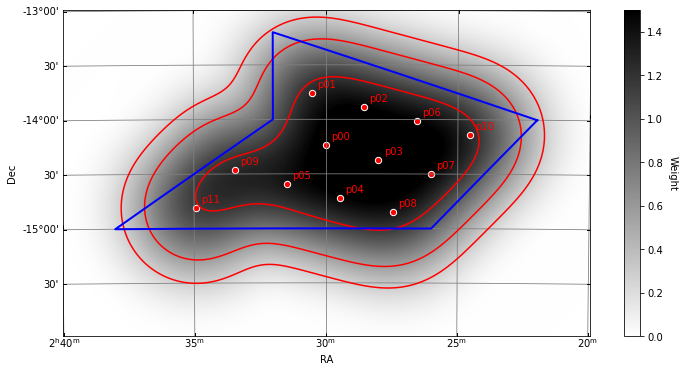

In [51]:
##############################################################################################################
# you can but you don't have to change the following (better don't touch unless you know what you are doing) #
##############################################################################################################
# For queries contact GIGJ

import numpy as np

def intersectioning(thalist, sections):
    """
    Inserts sections-2 numbers between each number in thalist and returns the result as separate list
    
    thalist (list of float): a list of floats
    """
    outl = []
    for i in range(len(thalist)-1):
        outl += list(np.linspace(thalist[i],thalist[i+1],sections,False))
    outl += [thalist[-1]]
    return outl

def plotmosweight(hduin, channel = 0, rms = None, vmin=0, vmax=1, cmap = 'gray_r', rmscontours = [0.001, 0.002], 
                  rmscol = 'red', ras = [], decs = [], names = [], polyra = [], polydec = [], polcol = 'b', 
                  fontsize = 20, thaplot = ''):
    """
    Plot the weight pattern as supplied by a weight cube hdu hdu as a greyscale map, overlay contours
    of the rms numpy cube at channel channel. Plot a cross at the position of ras and decs with labels names of 
    fontsize fontsize, draw a polygon
    with corners polyra and polydec with color polcol
    """
    
    from matplotlib import pyplot as plt
    from matplotlib import colors

    # Try it out, read wcs info from input hdu
    wt = wcs.WCS(hduin.header)
    
    w = reducedim(wt)
    
    # Build the data array
    data = hduin.data[channel,:]

    # Build hdu
    header = w.to_header()
    hdu = fits.PrimaryHDU(header=header, data=data)

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1, projection=w)
    
    # Comment out following line for Test 1 below
    im = ax.imshow(hdu.data, vmin=vmin, vmax=vmax, cmap=cmap, origin='lower')
    
    # Test 1: plot selected area in map, should look like polygon
    # polyran, polydecn = returnradecindeg(polyra, polydec)
    # vertices = np.array(w.wcs_world2pix(polyran,polydecn,0))
    # verticesx = vertices[0,:]
    # verticesy = vertices[1,:]    
    # thething = get_logical_insidemap(rms, verticesx, verticesy)
    # thething = thething.astype(float)
    # im = ax.imshow(thething[0,:], vmin=vmin, vmax=vmax, cmap=cmap, origin='lower')
    
    ax.grid(color='gray', ls='solid')
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.tick_params(direction='in')
    nu = wt.wcs_pix2world([[0.,0.,channel]], 0)[:,2][0]/1E9
    print('Frequency: {:.2f} GHz'.format(nu))
    if type(rms) != type(None):
        ax.contour(rms[channel,:], levels=rmscontours, colors = rmscol)
        levelprints = ''
        for i in range(len(rmscontours)):
            levelprints = levelprints+',{:0.2f}'.format(rmscontours[i]*1000.)
        print('Contours represent sensitivities of {:s} mJy'.format(levelprints[1:]))

        ax.scatter(ras, decs, s=40, edgecolor='white', facecolor=rmscol, transform=ax.get_transform('world'))
        if names != []:
            for i in range(len(ras)):
                if len(names) == i:
                    names = names + names[-1]
                ax.text(ras[i]-0.05, decs[i]+0.05, names[i], transform=ax.get_transform('world'), fontsize=fontsize, color='red')
    if polyra != []:
        polyran, polydecn = returnradecindeg(polyra, polydec)
        
        # Test 2: print coordinates of vertices of polygon
        # from astropy import units as u
        # for ind in range(len(polyran)):
        #     c = coordinates.SkyCoord(ra=polyran[ind]*u.degree, dec=polydecn[ind]*u.degree)
        #     print(c.to_string('hmsdms'))
        polyran = polyran.tolist()
        polydecn = polydecn.tolist()
        polyran.append(polyran[0])
        polydecn.append(polydecn[0])
        polyran=intersectioning(polyran, 50)
        polydecn=intersectioning(polydecn, 50)
        ax.plot(polyran, polydecn, color=polcol, linewidth = 2, transform=ax.get_transform('world'))
       
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Weight', rotation=270)
    cbar.ax.get_yaxis().labelpad = 15
    
    if thaplot != '':
        fig.savefig(thaplot)
    
plotmosweight(hdu, channel = mapchannel, rms = rms, vmin=vmin, vmax=vmax, cmap = 'gray_r', 
              rmscontours = rmscontours, rmscol = 'red', ras = ras, decs = decs, names = names, 
              polyra = polypointsra, polydec = polypointsdec, fontsize = 10, thaplot = pointpos_plot)

In [60]:
##############################################################################################################
# you can but you don't have to change the following (better don't touch unless you know what you are doing) #
##############################################################################################################
# For queries contact GIGJ
def printmospos(ras = [], decs = [], names = [], mosposfile = ''):
    """
    Print mosaic positions
    """
    if ras != []:
        if mosposfile != '':
            output = open(mosposfile, 'w')
        print('Pointings:')
        for ind in range(len(ras)):
            c = coordinates.SkyCoord(ra=ras[ind]*units.degree, dec=decs[ind]*units.degree)
            rastr = coordinates.Angle(ras[ind]*units.degree).to_string(unit='h',sep=':',alwayssign=False,precision=2,pad=True)
            destr = coordinates.Angle(decs[ind]*units.degree).to_string(unit='deg',sep=':',alwayssign=True,precision=1,pad=True)
            if names != []:
                ourstring = '{0:s}: {1:s} or {2:s} (deg)'.format(names[ind], c.to_string('hmsdms',alwayssign=False,precision=2,pad=True),c.to_string('decimal',alwayssign=False,precision=5,pad=True))
                csvstring = '{0:s}, radec target, {1:s}, {2:s}'.format(names[ind], rastr, destr)
      #          ourstring = '{0:s}, radec target, {1:s}, {2:s}'.format(names[ind], rastr, destr)
            else:
                ourstring = '{0:s} or {1:s} (deg)'.format(c.to_string('hmsdms'), c.to_string('decimal'))
                csvstring = 't{0:02d}, radec target, {1:s}, {2:s}'.format(ind, rastr, destr)
            print(ourstring)
            output.write(csvstring+'\n')
printmospos(ras = ras, decs = decs, names = names, mosposfile = pointpos_ascii)

Pointings:
p00: 02h30m00.00s -14d14m24.00s or 37.50000 -14.24000 (deg)
p01: 02h30m31.98s -13d45m25.18s or 37.63323 -13.75699 (deg)
p02: 02h28m32.59s -13d53m10.20s or 37.13580 -13.88617 (deg)
p03: 02h28m00.34s -14d22m08.01s or 37.00143 -14.36889 (deg)
p04: 02h29m27.89s -14d43m22.55s or 37.36620 -14.72293 (deg)
p05: 02h31m27.68s -14d35m35.80s or 37.86534 -14.59328 (deg)
p06: 02h26m33.07s -14d00m51.51s or 36.63779 -14.01431 (deg)
p07: 02h26m00.54s -14d29m48.30s or 36.50226 -14.49675 (deg)
p08: 02h27m27.95s -14d51m05.58s or 36.86645 -14.85155 (deg)
p09: 02h33m27.34s -14d27m45.34s or 38.36393 -14.46259 (deg)
p10: 02h24m33.40s -14d08m29.08s or 36.13916 -14.14141 (deg)
p11: 02h34m55.46s -14d48m52.42s or 38.73108 -14.81456 (deg)
